In [2]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose      
from pmdarima import auto_arima                              
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('data/co2_mm_mlo.csv')

In [3]:
df.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


In [4]:
df.index

RangeIndex(start=0, stop=729, step=1)

In [5]:
df['date']=pd.to_datetime(dict(year=df['year'], month=df['month'], day=1))
df.set_index('date',inplace=True)
df.index.freq = 'MS'
df.head()

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


<AxesSubplot:xlabel='date'>

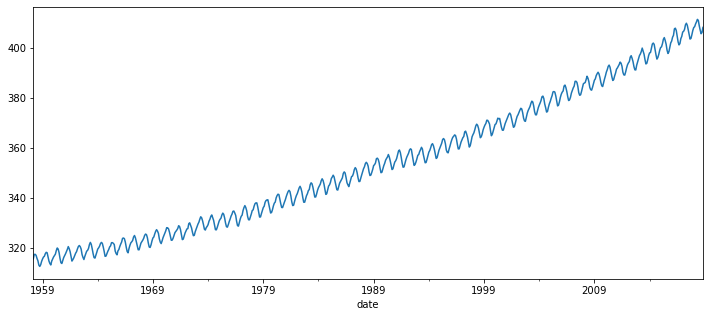

In [8]:
df['interpolated'].plot(figsize=(12,5))

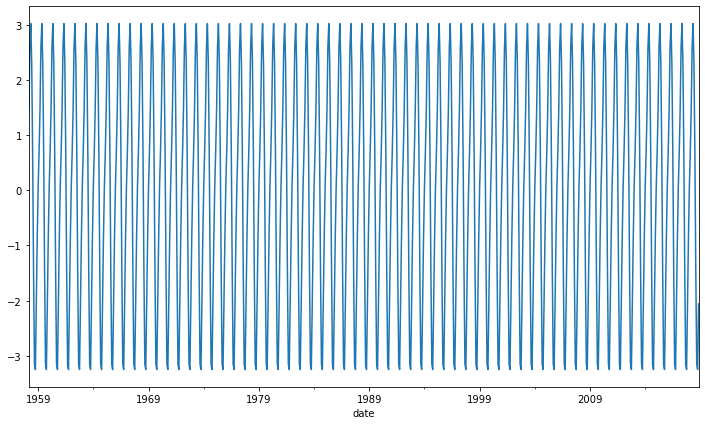

In [12]:
seasonal_decompose(df['interpolated']).seasonal.plot(figsize=(12,7));

Data seems to be seasonal over a period of year

In [14]:
auto_arima(df['interpolated'], seasonal=True, m=12,
          trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=458.371, Time=2.17 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2369.532, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1614.808, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2375.248, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=1101.954, Time=2.06 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=770.624, Time=1.78 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=501.138, Time=5.31 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=544.725, Time=4.94 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1440.918, Time=0.61 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=4.79 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=611.731, Time=5.71 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=5.97 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=451.828, Time=2.66 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : A

ARIMA(order=(0, 1, 3), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [16]:
len(df)

729

In [29]:
train = df.iloc[:717]
test = df.iloc[717:]

In [30]:
fitted_model = SARIMAX(train['interpolated'],order=(0,1,3),seasonal_order=(1,0,1,12)).fit()

In [31]:
# making the predictions on the test set
start = len(train)
end = len(train) + len(test) - 1

## Always remember to use typ='levels' while predicting the values for the time series using the fitted model. This is will give us the predicted values in its original form but not in the differenced form

In [32]:
predictions = fitted_model.predict(start=start,end=end,dynamic=False,typ='levels')

In [33]:
predictions.rename('SARIMA Model Predictions',inplace=True)

2017-12-01    406.609703
2018-01-01    407.824572
2018-02-01    408.578577
2018-03-01    409.483498
2018-04-01    411.038772
2018-05-01    411.641645
2018-06-01    410.862541
2018-07-01    409.173199
2018-08-01    407.072991
2018-09-01    405.622605
2018-10-01    405.892276
2018-11-01    407.425204
Freq: MS, Name: SARIMA Model Predictions, dtype: float64

<AxesSubplot:xlabel='date'>

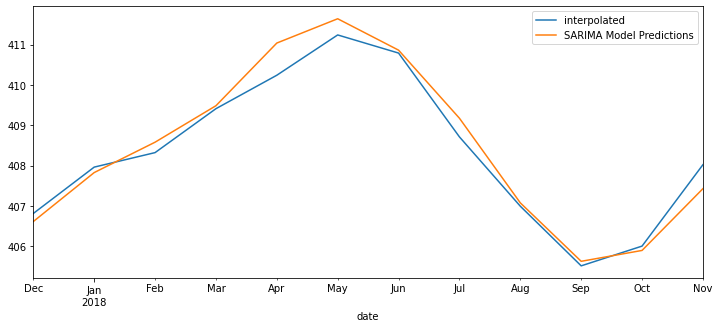

In [34]:
## plotting the test set with its predictions using the fitted model
test['interpolated'].plot(figsize=(12,5),legend=True)
predictions.plot(legend=True)

In [35]:
## checking the accuracy of the model quantitatively using the rmse
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(test['interpolated'],predictions))

In [36]:
## finding the mean of the test set
test_mean = test['interpolated'].mean()

In [37]:
rmse

0.3576366587203376

In [28]:
test_mean

408.3333333333333

error is quite low

In [38]:
## retraining the model on the whole data and then forecasting into the future
final_model = SARIMAX(df['interpolated'],order=(0,1,3),seasonal_order=(1,0,1,12)).fit()

In [39]:
fcast = final_model.predict(len(df),len(df)+11,typ='levels').rename('SARIMA Final Model Predictions')

<AxesSubplot:xlabel='date'>

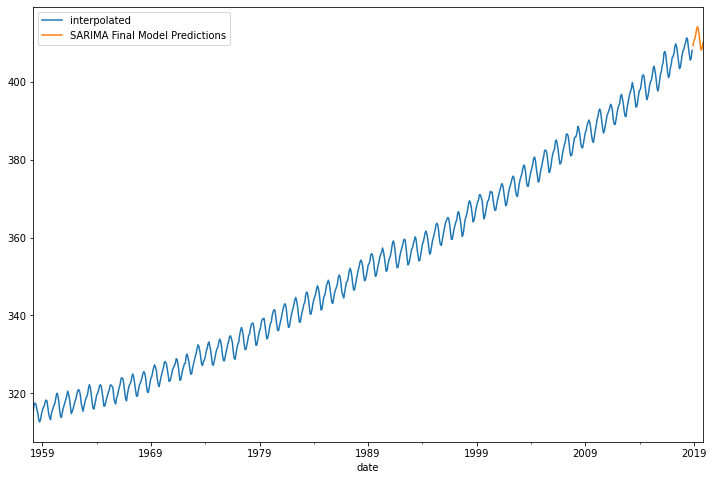

In [41]:
## plotting the whole data with the forecasted values
df['interpolated'].plot(figsize=(12,8),legend=True)
fcast.plot(legend=True)